# Test audiointerp/processing

In [32]:
from audiointerp.processing.spectrogram import STFTSpectrogram, LogSTFTSpectrogram, MelSTFTSpectrogram, LogMelSTFTSpectrogram
import torch.nn as nn
import torchaudio.transforms as T_audio
import torchaudio.functional as F_audio
import torchaudio
import torch
import matplotlib.pyplot as plt
from audiointerp.dataset.esc50 import ESC50dataset
from torch.utils.data import DataLoader
from IPython.display import Audio

In [8]:
sample = "samples/crow.wav"

In [9]:
root_dir = "/home/yuliya/ESC50"
sr = 32000
test_folds = [5]

In [10]:
n_fft = 1024
hop_length = 320
win_length = 1024
n_mels = 64
f_min = 50
f_max = 14000

In [11]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize=(10, 2))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
          axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
          axes[c].set_xlim(xlim)
        if ylim:
          axes[c].set_ylim(ylim)
          
    figure.suptitle(title)
    plt.show(block=False)

In [12]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    spec = spec.squeeze().cpu().numpy()
    fig, axs = plt.subplots(1, 1, figsize=(12, 4))
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(spec, origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [13]:
test_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=test_folds)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [14]:
for X, y in test_loader:
    test_batch = X
    break

In [15]:
test_sample, SR = torchaudio.load(sample)
test_sample = F_audio.resample(test_sample, SR, sr)

In [ ]:
stft_torch = T_audio.MelSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=1.
)

In [17]:
stft_mine = STFTSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=1.
)

In [180]:
Audio(test_sample, rate=sr)

In [181]:
res_sample_torch = stft_torch(test_sample)
res_sample_mine, res_sample_phase_mine = stft_mine(test_sample)

In [182]:
torch.equal(res_sample_torch, res_sample_mine)

True

In [183]:
res_batch_torch = stft_torch(test_batch)
res_batch_mine, res_batch_phase_mine = stft_mine(test_batch)

In [184]:
torch.equal(res_batch_torch, res_batch_mine)

True

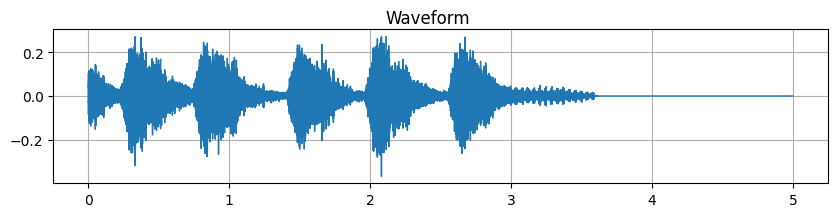

In [185]:
plot_waveform(test_sample, sr)

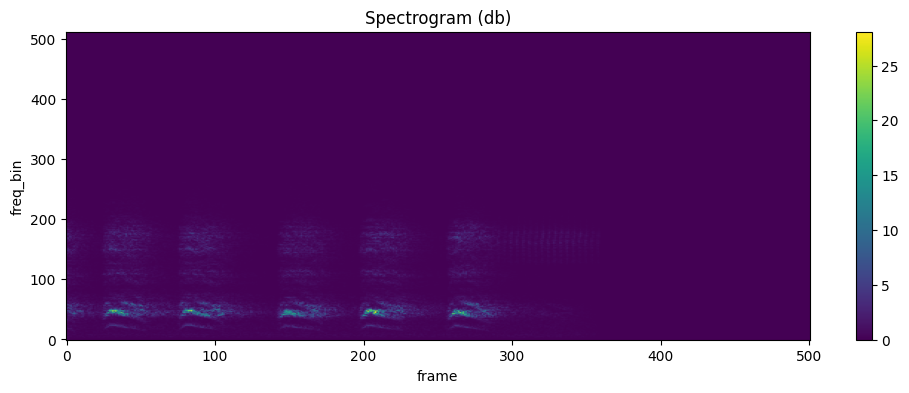

In [186]:
plot_spectrogram(res_sample_mine.abs())

In [187]:
r = stft_mine.inverse(res_sample_mine, res_sample_phase_mine)

In [188]:
Audio(r, rate=sr)

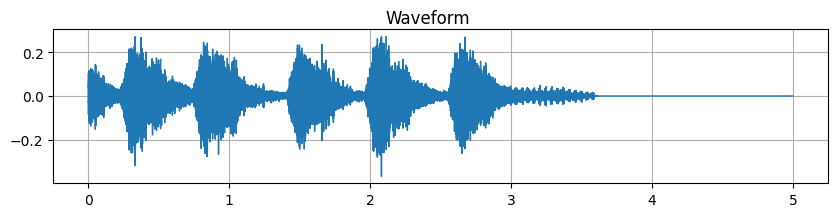

In [189]:
plot_waveform(test_sample, sr)

In [190]:
(r - test_sample).abs().max()

tensor(8.9407e-08)

In [ ]:
import torch
from audiointerp.processing.spectrogram import (
    STFTSpectrogram, LogSTFTSpectrogram,
    MelSTFTSpectrogram, LogMelSTFTSpectrogram
)

def test_spectrogram_classes():
    sr = 32000
    duration = 1.0
    t = torch.linspace(0, duration, int(sr * duration))
    wave = test_sample

    print("Testing STFTSpectrogram:")
    stft_proc = STFTSpectrogram(n_fft=n_fft, hop_length=64, win_length=256, return_phase=True, power=1.)
    spec, phase = stft_proc(wave)
    recon_wave_stft = stft_proc.inverse(spec, phase)
    print(" Shapes => wave:", wave.shape, " | spec:", spec.shape, " | recon:", recon_wave_stft.shape)

    print("\nTesting LogSTFTSpectrogram:")
    logstft_proc = LogSTFTSpectrogram(n_fft=256, hop_length=64, win_length=256, return_phase=True, power=1.)
    spec_db, phase_db, full_db = logstft_proc(wave)
    recon_wave_logstft = logstft_proc.inverse(spec_db, phase_db, full_db=full_db)
    print(" Shapes => wave:", wave.shape, " | spec_db:", spec_db.shape, " | recon:", recon_wave_logstft.shape)

    print("\nTesting MelSTFTSpectrogram:")
    mel_proc = MelSTFTSpectrogram(n_fft=256, hop_length=64, win_length=256, sample_rate=sr, return_phase=True, n_mels=40, power=1.)
    mel_spec, mel_phase = mel_proc(wave)
    recon_wave_mel = mel_proc.inverse(mel_spec, mel_phase)
    print(" Shapes => wave:", wave.shape, " | mel_spec:", mel_spec.shape, " | recon:", recon_wave_mel.shape)

    print("\nTesting LogMelSTFTSpectrogram:")
    logmel_proc = LogMelSTFTSpectrogram(n_fft=256, hop_length=64, win_length=256, sample_rate=sr, return_phase=True, n_mels=40, power=1.)
    logmel_spec, logmel_phase, logmel_full_db = logmel_proc(wave)
    recon_wave_logmel = logmel_proc.inverse(logmel_spec, logmel_phase, full_db=logmel_full_db)
    print(" Shapes => wave:", wave.shape, " | logmel_spec:", logmel_spec.shape, " | recon:", recon_wave_logmel.shape)


if __name__ == "__main__":
    test_spectrogram_classes()


Testing STFTSpectrogram:
 Shapes => wave: torch.Size([1, 160000])  | spec: torch.Size([1, 513, 2501])  | recon: torch.Size([1, 160000])

Testing LogSTFTSpectrogram:
 Shapes => wave: torch.Size([1, 160000])  | spec_db: torch.Size([1, 129, 2501])  | recon: torch.Size([1, 160000])

Testing MelSTFTSpectrogram:
 Shapes => wave: torch.Size([1, 160000])  | mel_spec: torch.Size([1, 40, 2501])  | recon: torch.Size([1, 160000])

Testing LogMelSTFTSpectrogram:
 Shapes => wave: torch.Size([1, 160000])  | logmel_spec: torch.Size([1, 40, 2501])  | recon: torch.Size([1, 160000])


In [ ]:
import torch
from audiointerp.processing.spectrogram import (
    STFTSpectrogram, LogSTFTSpectrogram,
    MelSTFTSpectrogram, LogMelSTFTSpectrogram
)

def test_max_abs_diff():
    sr = 8000
    duration = 1.0
    t = torch.linspace(0, duration, int(sr * duration))
    wave = test_batch
    
    processors = {
        "STFT": STFTSpectrogram(n_fft=256, hop_length=64, win_length=256, return_phase=True, power=1.),
        "LogSTFT": LogSTFTSpectrogram(n_fft=256, hop_length=64, win_length=256, return_phase=True, power=1.),
        "MelSTFT": MelSTFTSpectrogram(n_fft=256, hop_length=64, win_length=256, return_phase=True, sample_rate=sr, n_mels=40, power=1.),
        "LogMelSTFT": LogMelSTFTSpectrogram(n_fft=256, hop_length=64, win_length=256, return_phase=True, sample_rate=sr, n_mels=40, power=1.),
    }

    for name, proc in processors.items():
        if proc.return_phase:
            out = proc(wave)
            if isinstance(out, tuple):
                if len(out) == 2:
                    spec, phase = out
                    recon = proc.inverse(spec, phase=phase)
                elif len(out) == 3:
                    spec, phase, full_db = out
                    recon = proc.inverse(spec, phase=phase, full_db=full_db)
                else:
                    raise ValueError(f"Unexpected output shape from {name}")
            else:
                raise ValueError(f"Expected return_phase output from {name}")
        else:
            spec = proc(wave)
            recon = proc.inverse(spec)

        diff = (wave - recon).abs().max().item()
        print(recon.isnan().any())
        print(f"{name} max abs difference: {diff:.6f}")

if __name__ == "__main__":
    test_max_abs_diff()

tensor(False)
STFT max abs difference: 0.000000
tensor(False)
LogSTFT max abs difference: 0.000001
tensor(False)
MelSTFT max abs difference: 0.666704
tensor(False)
LogMelSTFT max abs difference: 0.666704


In [28]:
Audio(test_sample, rate=sr)

In [35]:
sr = 32000

In [36]:
amplitude_to_db = T_audio.AmplitudeToDB(stype="power", top_db=80)

In [43]:
stft = T_audio.Spectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=2.
)

stft_mine = STFTSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=2.
)

In [44]:
log_stft = nn.Sequential(stft, amplitude_to_db)

log_stft_mine = LogSTFTSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=2., top_db=80
)

In [45]:
mel_stft = T_audio.MelSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=2., sample_rate=sr, n_mels=n_mels, f_min=f_min, f_max=f_max
)

mel_stft_mine = MelSTFTSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=2., sample_rate=sr, n_mels=n_mels, f_min=f_min, f_max=f_max
)

In [46]:
logmel_stft = nn.Sequential(mel_stft, amplitude_to_db)

logmel_stft_mine = LogMelSTFTSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=2., sample_rate=sr, n_mels=n_mels, f_min=f_min, f_max=f_max, top_db=80
)

In [89]:
res, phase, amp = log_stft_mine(test_sample)
res_orig = log_stft(test_sample)
recon = log_stft_mine.inverse(res, phase=phase, full_db=amp)

In [90]:
print(torch.equal(res_orig,res))

True


In [91]:
print((test_sample - recon).abs().max())

tensor(1.6975e-06)


In [92]:
Audio(recon, rate=sr)

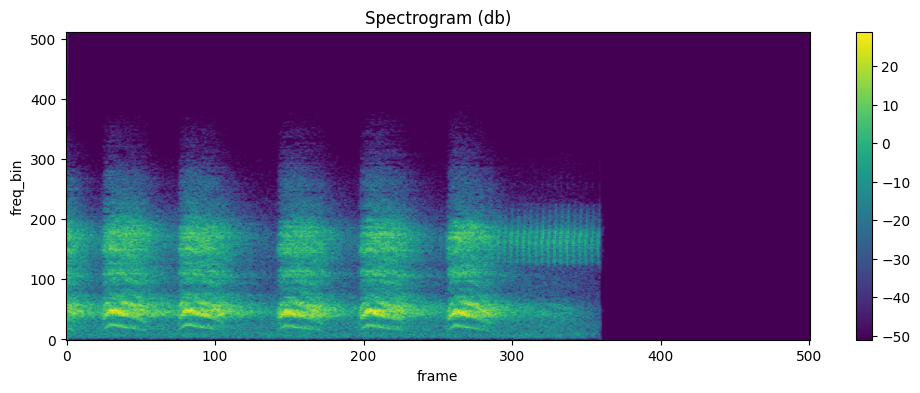

In [93]:
plot_spectrogram(res)

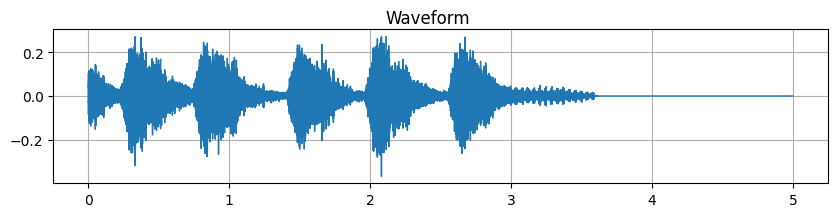

In [94]:
plot_waveform(test_sample, sample_rate=sr)

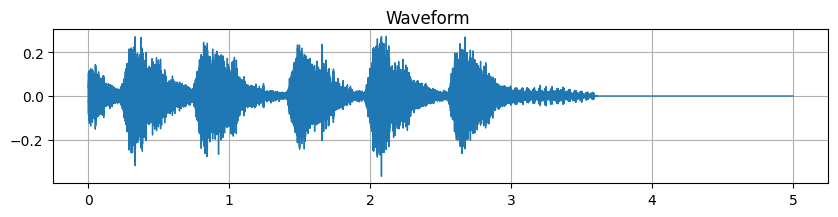

In [95]:
plot_waveform(recon, sample_rate=sr)